In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from interaction_inference import dataset, optimization

## Dataset (PNAS Smart-seq-total paper)

Load dataset of single genes

In [2]:
data_FIB = pd.read_csv("./Datasets/GSE151334_FIB_counts_thresh.csv", index_col=0)

## Capture efficiency

Estimate capture efficiency per cell from the full dataset of genes:
- set a mean value <$\beta$>
- compute the total counts per cell / total counts across all cells
- renormalize to have mean <$\beta$>, giving capture efficiency $\beta_{j}$ per cell

In [32]:
# mean beta
beta_mean = 0.1

# total counts per cell
total_per_cell = data_FIB.sum(axis='rows')

# total counts across all cells
total_overall = total_per_cell.sum()

# count proportions per cell (sum = 1)
count_proportion = (total_per_cell / total_overall).to_numpy()

# number of cells
n = count_proportion.size

# re-normalize
beta = count_proportion * beta_mean * n

In [198]:
# set mean beta
MeanBETA = 0.1

#xx<-Matrix::colSums(Data)
xx = data_FIB.sum(axis='rows')

#Normcount <- t_sp(t_sp(Data)/xx) * mean(xx)
# Normcount <- Matrix::t(Matrix::t(Data)/xx) * mean(xx)
Normcount = (data_FIB / xx) * np.mean(xx) # sum = mean(xx) per column

#means <- Matrix::rowMeans(Normcount)
means = Normcount.mean(axis='columns')

#lmeans <- log(means)
lmean = np.log(means)

#med <- apply(log(Normcount + 1), 1, function(x) {
#    median(x)
#})
med = np.log(Normcount + 1).median(axis=1)

#mad <- apply(log(Normcount + 1), 1, function(x) {
#    mad(x)
#})
mad = np.log(Normcount + 1).apply(lambda row: (row - row.median()).abs().median(), axis=1)

#bound <- med + 3 * mad
bound = med + 3*mad

#maxlogGene <- apply(log(Normcount + 1), 1, max)
maxlogGene = np.log(Normcount + 1).max(axis=1)

#ind <- which(maxlogGene < bound)
ind = maxlogGene < bound

#dropout = apply(Data, 1, function(x) {
#    length(which(x == 0))/length(x)
#})
dropout = data_FIB.apply(lambda row: (row == 0).sum() / row.size, axis=1)


#Select_ind <- intersect(ind, which(dropout < 0.35))
Select_ind = ind & (dropout < 0.35)

# Selected_genes <- rownames(Data)[Select_ind]
Selected_genes = list(Select_ind.index)

#temppp <- Matrix::colSums(Data[Select_ind, ])
temppp = data_FIB[Select_ind].sum(axis=0)

#BETA <- temppp/mean(temppp) * MeanBETA
BETA = (temppp / temppp.mean()) * MeanBETA

#if (length(which(BETA >= 1)) > 0) {
#    BETA[BETA >= 1] = max(BETA[BETA < 1])
#}
#if (length(which(BETA <= 0)) > 0) {
#    BETA[BETA <= 0] = min(BETA[BETA > 0])
#}
if (BETA >= 1).size > 0:
    BETA[BETA >= 1] = BETA[BETA < 1].max()
if (BETA <= 0).size > 0:
    BETA[BETA <= 0] = BETA[BETA > 0].min()

#names(BETA) <- colnames(Data)

#return(list(BETA = BETA, Selected_genes = Selected_genes))
BETA = BETA.to_numpy()

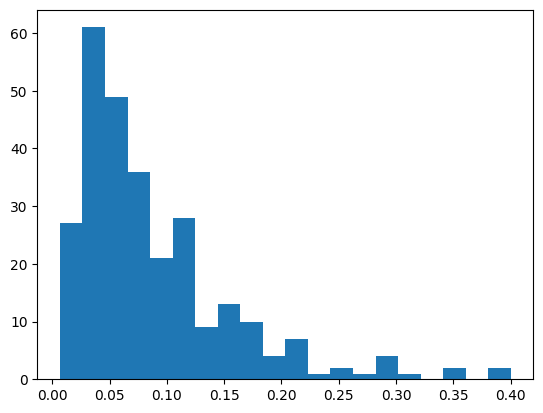

In [199]:
plt.hist(BETA, bins=20);

### Construct dataset of pairs

Avoid repeating pairs as symmetric

In [245]:
# size
genes = 100
gene_pairs = (genes * (genes - 1) // 2) + genes
cells = data_FIB.shape[1]

# construct paired count dataframe
counts_df = pd.DataFrame(
    index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
    columns = [f"Cell-{j}" for j in range(cells)]
)

# fill with pairs
k = 0
for i in range(genes):
    gene_i = data_FIB.iloc[i]
    for j in range(genes):
        if j > i:
            break
        gene_j = data_FIB.iloc[j]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[k] = gene_pair_ij
        k += 1

# construct object
dataset_FIB = dataset.Dataset("dataset_FIB")
dataset_FIB.count_dataset = counts_df
dataset_FIB.cells = cells
dataset_FIB.gene_pairs = gene_pairs

# settings
dataset_FIB.thresh_OB = 3
dataset_FIB.threshM_OB = 3

# set capture
dataset_FIB.beta = BETA

### Moment optimization

In [246]:
# memory settings
dataset_FIB.resamples = 1000

In [247]:
dataset_FIB.compute_moments(tqdm_disable=False)

100%|██████████| 5050/5050 [01:18<00:00, 64.66it/s]


In [248]:
# optimization analysis
moment_FIB = optimization.Optimization(
    dataset_FIB,
    [
        "dummy_moment"
    ],
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 5050/5050 [00:08<00:00, 608.50it/s]


In [249]:
result_array = np.zeros((genes, genes))
k = 0
for i in range(genes):
    for j in range(genes):
        # ignore above diagonal
        if j > i:
            pass
        else:
            if moment_FIB.result_dict[k]['status'] == "INFEASIBLE":
                result_array[i, j] = 1
            k += 1

# fill above diagonal by symmetry
for i in range(genes):
    for j in range(genes):
        if j > i:
            result_array[i, j] = result_array[j, i]

(np.float64(-0.5), np.float64(99.5), np.float64(99.5), np.float64(-0.5))

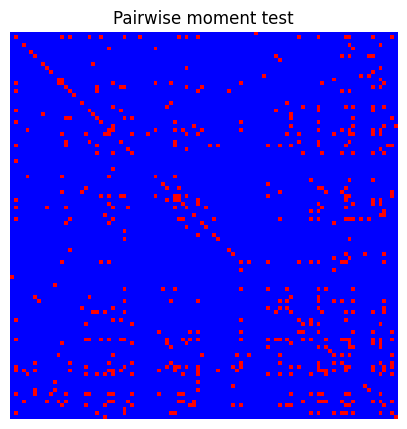

In [250]:
fig, axs = plt.subplots(figsize=(5, 6))
cmap = LinearSegmentedColormap.from_list('br', [(0, "b"), (1, "r")], N=256)
vmin, vmax = 0, 1
img = axs.imshow(result_array, cmap=cmap, vmin=vmin, vmax=vmax)
axs.set_title("Pairwise moment test")
plt.axis('off')
#cbar = plt.colorbar(img, ax=axs)
#cbar.set_label("p-value")

### Construct dataset single genes (paired to save space)

i.e. (X1, X2), (X3, X4), ... 

for marginal optimization

In [262]:
# size
genes = 50
gene_pairs = genes // 2
cells = data_FIB.shape[1]

# construct paired count dataframe
counts_df = pd.DataFrame(
    index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
    columns = [f"Cell-{j}" for j in range(cells)]
)

# fill with pairs
i = 0
for k in range(gene_pairs):
    gene_i = data_FIB.iloc[i]
    gene_j = data_FIB.iloc[i + 1]
    gene_pair_ij = list(zip(gene_i, gene_j))
    counts_df.iloc[k] = gene_pair_ij
    i += 2

# construct object
dataset_single_FIB = dataset.Dataset("dataset_single_FIB")
dataset_single_FIB.count_dataset = counts_df
dataset_single_FIB.cells = cells
dataset_single_FIB.gene_pairs = gene_pairs

# settings
dataset_FIB.thresh_OB = 3
dataset_FIB.threshM_OB = 3

# set capture
dataset_single_FIB.beta = BETA

### Marginal optimization

In [282]:
# memory details
dataset_single_FIB.splits = 100
dataset_single_FIB.resamples = 1000

In [283]:
dataset_single_FIB.bootstrap_probabilities(tqdm_disable=False)

 68%|██████▊   | 17/25 [00:54<00:25,  3.22s/it]


MemoryError: Unable to allocate 7.83 GiB for an array with shape (1000, 1554, 1352) and data type uint32

In [255]:
dataset_single_FIB.compute_fm(tqdm_disable=False)

100%|██████████| 5/5 [00:40<00:00,  8.01s/it]


In [256]:
# optimization analysis
odd_results = optimization.Optimization(
    dataset_single_FIB,
    [
        "downsampled_marginal_probability_1",
        "downsampled_marginal_CME_1",
        "k_deg_1"
    ],
    tqdm_disable=False,
    print_solution=False
)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 84.56it/s]

Optimization failed
Optimization failed
Optimization failed


In [257]:
# optimization analysis
even_results = optimization.Optimization(
    dataset_single_FIB,
    [
        "downsampled_marginal_probability_2",
        "downsampled_marginal_CME_2",
        "k_deg_2"
    ],
    tqdm_disable=False,
    print_solution=False
)

100%|██████████| 5/5 [00:00<00:00, 131.79it/s]

Optimization failed


In [260]:
odd_results.result_dict

{0: {'status': 'OPTIMAL', 'time': 0.010999917984008789},
 1: {'status': None, 'time': 0.0},
 2: {'status': None, 'time': 0.0},
 3: {'status': 'OPTIMAL', 'time': 0.003000020980834961},
 4: {'status': None, 'time': 0.0}}

In [261]:
even_results.result_dict

{0: {'status': None, 'time': 0.0},
 1: {'status': 'OPTIMAL', 'time': 0.0019998550415039062},
 2: {'status': 'OPTIMAL', 'time': 0.003000020980834961},
 3: {'status': 'OPTIMAL', 'time': 0.002000093460083008},
 4: {'status': 'INFEASIBLE', 'time': 0.0010001659393310547}}